# Sistem Rekomendasi Berita & NER

Dataset berita diperoleh dari https://www.kaggle.com/datasets/sh1zuka/indonesia-news-dataset-2024

Model NER menggunakan https://huggingface.co/cahya/bert-base-indonesian-NER

Daftar Isi:
- [Rekomendasi dan Model](#rekomendasi-dan-model)
- [Pencarian](#pencarian)
- [Sentimen](#sentimen)
- [Interaktif rekomendasi](#interaktif-rekomendasi)
- [NER](#ner)

In [ ]:
!pip install nltk textBlob

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import joblib
import os
from multiprocessing import Pool

In [3]:
# Download stopwords
nltk.download('stopwords', quiet=True)

True

In [4]:
# Load dataset
df = pd.read_csv('/kaggle/input/indonesia-news-dataset-2024/politik_merge.csv')
print("Dataset loaded successfully.")
print(f"Shape of dataset: {df.shape}")
print("Columns:", df.columns.tolist())

Dataset loaded successfully.
Shape of dataset: (45781, 10)
Columns: ['Judul', 'Waktu', 'Link', 'Content', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'source']


## Preproses
Fungsi preprocess_text melakukan pembersihan dan normalisasi teks:
* Mengubah teks menjadi lowercase
* Menghapus tanda baca
* Menghapus angka
* Menghapus stopwords bahasa 

Preprocessing ini diterapkan pada kolom 'Content' dari dataframe.

In [5]:
# Preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [6]:
# Apply preprocessing to 'Content' column
df['processed_content'] = df['Content'].apply(preprocess_text)

## TF-IDF Vectorization
TF-IDF digunakan untuk mengubah teks menjadi vektor numerik, memperhitungkan frekuensi kata dalam dokumen dan kepentingannya dalam seluruh korpus.

In [7]:
# Create TF-IDF matrix
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['processed_content'])

<a id="Rekomendasi-dan-Model"></a>
## Cosine Similarity
Cosine similarity digunakan untuk mengukur kesamaan antara dokumen berdasarkan representasi TF-IDF mereka.

In [8]:
def batch_cosine_similarity(X, batch_size=1000):
    n_samples = X.shape[0]
    cosine_sim = np.zeros((n_samples, n_samples))
    
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        cosine_sim[i:i+batch_size] = cosine_similarity(batch, X)
    
    return cosine_sim

In [9]:
output_path = '/kaggle/working/'
cosine_sim_file = os.path.join(output_path, 'cosine_sim.joblib')

if os.path.exists(cosine_sim_file):
    print("Loading existing cosine similarity matrix...")
    cosine_sim = joblib.load(cosine_sim_file)
else:
    print("Computing cosine similarity matrix...")
    cosine_sim = batch_cosine_similarity(tfidf_matrix)
    print("Saving cosine similarity matrix...")
    joblib.dump(cosine_sim, cosine_sim_file)
    print("Cosine similarity matrix saved successfully.")

Loading existing cosine similarity matrix...


## Rekomendasi

In [10]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Cek apakah judul ada dalam DataFrame
    if title not in df['Judul'].values:
        return None, None  # Kembalikan None jika judul tidak ditemukan
    
    idx = df[df['Judul'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 similar items
    news_indices = [i[0] for i in sim_scores]
    recommended_titles = df['Judul'].iloc[news_indices]
    similarity_scores = [i[1] for i in sim_scores]
    return recommended_titles, similarity_scores

In [11]:
# Example usage
print("\nContoh Rekomendasi:")
sample_title = df['Judul'].iloc[0]  # Mengambil judul pertama sebagai contoh
print(f"Berita: {sample_title}")
print("\nRekomendasi berita serupa:")
recommendations = get_recommendations(sample_title)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


Contoh Rekomendasi:
Berita: Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta

Rekomendasi berita serupa:
1. 43449    KSP: Pakaian Adat Betawi Presiden Simbol Terim...
18064    7 Pakaian Adat yang Dikenakan Jokowi Saat Pida...
33840    Tentang Baju Kustin, Pakaian Adat Jokowi Saat ...
16692    Daftar Nama Pakaian Adat di Indonesia untuk Up...
31419    Daftar Nama Pakaian Adat di Indonesia untuk Up...
30419    Daftar Pencalonan ke KPUD, Pramono Kenakan Baj...
32512    Daftar Baju Adat yang Pernah Dipakai Jokowi sa...
39555    Jokowi Pakai Baju Adat Banjar di Upacara Penur...
44029    Pegiat HAM Sebut Pejabat Pakai Baju Adat Hanya...
28826    Jokowi di HUT RI IKN, Pakai Baju Adat Nusantar...
Name: Judul, dtype: object
2. [0.910518365091008, 0.7646547548277386, 0.5212104734929696, 0.5190423547246904, 0.5190423547246904, 0.49162659137557835, 0.48692501790473625, 0.4867819636478426, 0.47039985688304653, 0.46053857125236825]


## Pencarian

In [12]:
# Fungsi untuk mencari berita berdasarkan kata kunci
def search_news(keyword):
    return df[df['processed_content'].str.contains(keyword, case=False, na=False)]['Judul']


In [13]:
# Contoh pencarian
print("\nContoh Pencarian:")
keyword = "presiden"  # Ganti dengan kata kunci yang Anda inginkan
search_results = search_news(keyword)
print(f"Hasil pencarian untuk '{keyword}':")
for i, title in enumerate(search_results[:5], 1):  # Menampilkan 5 hasil pertama
    print(f"{i}. {title}")


Contoh Pencarian:
Hasil pencarian untuk 'presiden':
1. Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta
2. Amnesty International Beberkan 6 Indikator Krisis Demokrasi di Indonesia
3. Saat ASN Solo Ikut Lepas Gibran yang Resmi Mundur Menjelang Pelantikan Wakil Presiden
4. Airlangga Hartarto Mundur dari Ketum, Golkar Bantah karena Korupsi dan Fokus Cari Pengganti
5. Gibran Akan Bertemu Jokowi dan Prabowo Setelah Lebaran di Solo


## Sentimen

In [14]:
# Analisis Sentimen
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [15]:
# Sebelum melakukan analisis atau visualisasi, mengganti nilai inf
df['Content'] = df['Content'].replace([np.inf, -np.inf], np.nan)

# Kemudian lanjutkan analisis sentiment
df['Content'] = df['Content'].astype(str)
df['sentiment'] = df['Content'].apply(analyze_sentiment)


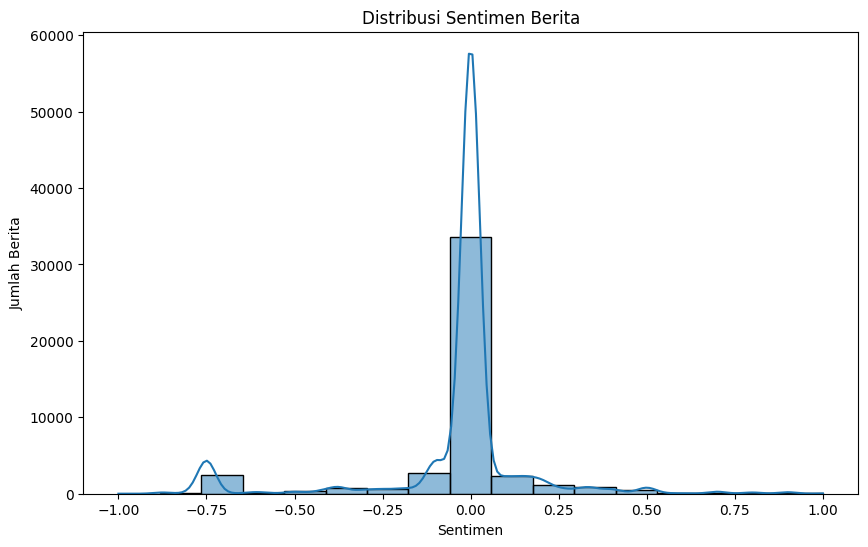

In [16]:
# Visualisasi
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Distribusi Sentimen Berita')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Berita')
plt.show()

Analisis:
* Distribusi Sentral: Mayoritas besar berita memiliki sentimen netral atau mendekati netral (sekitar 0 pada skala sentimen).
* Simetri: Distribusi cenderung simetris, dengan sedikit kecenderungan ke arah sentimen positif (sisi kanan grafik).
* Outliers: Terdapat beberapa outlier di kedua ujung spektrum, menunjukkan adanya berita dengan sentimen sangat positif atau sangat negatif, meskipun jumlahnya relatif kecil.
* Puncak Tajam: Grafik menunjukkan puncak yang sangat tajam di sekitar 0, mengindikasikan bahwa sebagian besar berita cenderung netral atau objektif.
* Ekor Tipis: Ekor distribusi yang tipis menunjukkan bahwa berita dengan sentimen ekstrem (baik sangat positif maupun sangat negatif) relatif jarang.

## Interaktif Rekomendasi

In [17]:
# Interaktivitas
while True:
    print("\n1. Cari berita")
    print("2. Dapatkan rekomendasi")
    print("3. Keluar")
    choice = input("Pilih opsi (1/2/3): ")
    
    if choice == '1':
        keyword = input("Masukkan kata kunci pencarian: ")
        results = search_news(keyword)
        print(f"\nHasil pencarian untuk '{keyword}':")
        for i, title in enumerate(results[:5], 1):
            print(f"{i}. {title}")
    
    elif choice == '2':
        title = input("Masukkan judul berita untuk rekomendasi: ")
        recommendations, scores = get_recommendations(title)
        if recommendations is None:
            print(f"Judul '{title}' tidak ditemukan dalam database.")
        else:
            print("\nRekomendasi berita serupa:")
            for i, (rec, score) in enumerate(zip(recommendations, scores), 1):
                print(f"{i}. {rec} (Similarity: {score:.2f})")
    
    elif choice == '3':
        print("Terima kasih! Sampai jumpa.")
        break
    
    else:
        print("Pilihan tidak valid. Silakan coba lagi.")


1. Cari berita
2. Dapatkan rekomendasi
3. Keluar


Pilih opsi (1/2/3):  1
Masukkan kata kunci pencarian:  presiden



Hasil pencarian untuk 'presiden':
1. Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta
2. Amnesty International Beberkan 6 Indikator Krisis Demokrasi di Indonesia
3. Saat ASN Solo Ikut Lepas Gibran yang Resmi Mundur Menjelang Pelantikan Wakil Presiden
4. Airlangga Hartarto Mundur dari Ketum, Golkar Bantah karena Korupsi dan Fokus Cari Pengganti
5. Gibran Akan Bertemu Jokowi dan Prabowo Setelah Lebaran di Solo

1. Cari berita
2. Dapatkan rekomendasi
3. Keluar


Pilih opsi (1/2/3):  2
Masukkan judul berita untuk rekomendasi:  Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta



Rekomendasi berita serupa:
1. KSP: Pakaian Adat Betawi Presiden Simbol Terima Kasih untuk Ibu Kota Jakarta (Similarity: 0.91)
2. 7 Pakaian Adat yang Dikenakan Jokowi Saat Pidato Kenegaraan, Betawi Jadi Pemungkas (Similarity: 0.76)
3. Tentang Baju Kustin, Pakaian Adat Jokowi Saat Upacara 17 Agustus 2024 (Similarity: 0.52)
4. Daftar Nama Pakaian Adat di Indonesia untuk Upacara 17 Agustus (Similarity: 0.52)
5. Daftar Nama Pakaian Adat di Indonesia untuk Upacara 17 Agustus (Similarity: 0.52)
6. Daftar Pencalonan ke KPUD, Pramono Kenakan Baju Adat Betawi dan Naik Opelet (Similarity: 0.49)
7. Daftar Baju Adat yang Pernah Dipakai Jokowi saat Upacara 17 Agustus (Similarity: 0.49)
8. Jokowi Pakai Baju Adat Banjar di Upacara Penurunan Bendera, Ini Maknanya (Similarity: 0.49)
9. Pegiat HAM Sebut Pejabat Pakai Baju Adat Hanya Gimik: RUU Perlindungan Masyarakat Adat Malah Enggak Dibahas (Similarity: 0.47)
10. Jokowi di HUT RI IKN, Pakai Baju Adat Nusantara Terinspirasi Adat Kustin Kukar (Similarit

Pilih opsi (1/2/3):  3


Terima kasih! Sampai jumpa.


## Evaluasi Model

In [18]:
# Fungsi untuk menghitung Precision at K
def precision_at_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

# Fungsi untuk menghitung Average Precision
def average_precision(actual, predicted):
    ap = 0.0
    relevant_count = 0
    for i, p in enumerate(predicted):
        if p in actual:
            relevant_count += 1
            ap += relevant_count / (i + 1)
    return ap / len(actual) if len(actual) > 0 else 0

# Fungsi untuk menghitung NDCG
def ndcg_at_k(actual, predicted, k):
    dcg = 0
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(k, len(actual)))])
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            dcg += 1.0 / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0

# Fungsi untuk mendapatkan berita yang mirip berdasarkan cosine similarity
def get_similar_articles(title, df, cosine_sim, threshold=0.5):
    idx = df[df['Judul'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [i for i in sim_scores if i[1] > threshold]
    article_indices = [i[0] for i in sim_scores]
    return df['Judul'].iloc[article_indices].tolist()

# Fungsi untuk melakukan evaluasi
def evaluate_model(df, cosine_sim, num_samples=100, k=10):
    # Split data menjadi train dan test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    precisions = []
    aps = []
    ndcgs = []
    
    for _ in range(num_samples):
        # Pilih berita secara acak dari test set
        sample = test_df.sample(n=1).iloc[0]
        actual_title = sample['Judul']
        
        # Dapatkan rekomendasi
        recommendations, _ = get_recommendations(actual_title, cosine_sim)
        
        if recommendations is not None:
            # Dapatkan artikel yang mirip sebagai "ground truth"
            actual_relevant = get_similar_articles(actual_title, df, cosine_sim)
            
            # Hitung metrik
            precisions.append(precision_at_k(actual_relevant, recommendations, k))
            aps.append(average_precision(actual_relevant, recommendations))
            ndcgs.append(ndcg_at_k(actual_relevant, recommendations, k))
    
    # Hitung rata-rata metrik
    avg_precision = np.mean(precisions)
    map_score = np.mean(aps)
    avg_ndcg = np.mean(ndcgs)
    
    return avg_precision, map_score, avg_ndcg

# Jalankan evaluasi
k = 10
avg_precision, map_score, avg_ndcg = evaluate_model(df, cosine_sim)

In [19]:
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Mean Average Precision: {map_score:.4f}")
print(f"Average NDCG@{k}: {avg_ndcg:.4f}")

Average Precision@10: 0.6310
Mean Average Precision: 0.4513
Average NDCG@10: 0.7718


# NER

Menerapkan teknik Named Entity Recognition (NER) untuk mengidentifikasi dan mengkategorikan entitas penting dalam berita.

In [49]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
from collections import Counter

In [70]:
def setup_ner():
    model_name = "cahya/bert-base-indonesian-NER"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    
    ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer, 
                        device=0 if torch.cuda.is_available() else -1)
    
    return ner_pipe

In [76]:
def perform_ner(ner_pipeline, text, max_length=510):
    if pd.isna(text) or text == '':
        return []
    
    # Tokenisasi teks
    encoding = ner_pipeline.tokenizer.encode_plus(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
    
    # Dapatkan token IDs
    input_ids = encoding['input_ids'][0]
    
    # Decode kembali ke teks
    truncated_text = ner_pipeline.tokenizer.decode(input_ids, skip_special_tokens=True)
    
    # Jalankan NER
    return ner_pipeline(truncated_text)

def map_label_to_entity(label):
    return label.split('-')[-1]

def process_text(text, ner_pipeline):
    entity_counter = Counter()
    word_counter = Counter()
    
    if pd.notna(text):
        try:
            entities = perform_ner(ner_pipeline, text)
            for entity in entities:
                if 'entity_group' in entity:
                    mapped_entity = map_label_to_entity(entity['entity_group'])
                elif 'entity' in entity:
                    mapped_entity = map_label_to_entity(entity['entity'])
                else:
                    mapped_entity = map_label_to_entity(str(entity))
                
                entity_counter[mapped_entity] += 1
                word_counter[entity['word']] += 1
        except Exception as e:
            print(f"Error processing text: {e}")
    
    return entity_counter, word_counter

In [ ]:
# Inisialisasi counter global
global_entity_counter = Counter()
global_word_counter = Counter()

# Setup NER pipeline
ner_pipeline = setup_ner()

# Gunakan DataFrame yang sudah didefinisikan
# df = pd.read_csv('/kaggle/input/indonesia-news-dataset-2024/politik_merge.csv')

# Batasi jumlah baris yang diproses jika perlu
max_rows = 5000
df = df.head(max_rows)

In [ ]:
# Proses setiap baris
for index, row in df.iterrows():
    for text_field in ['Judul', 'Content']:
        entity_counter, word_counter = process_text(row[text_field], ner_pipeline)
        global_entity_counter.update(entity_counter)
        global_word_counter.update(word_counter)
    
    if (index + 1) % 100 == 0:
        print(f"Processed {index + 1} rows")

In [79]:
# Analisis hasil
print("\nTop 10 Most Common Entities:")
for entity, count in global_entity_counter.most_common(10):
    print(f"{entity}: {count}")

print("\nTop 10 Most Common Words:")
for word, count in global_word_counter.most_common(10):
    print(f"{word}: {count}")


Top 10 Most Common Entities:
PER: 146710
NOR: 103489
ORG: 63237
DAT: 45661
EVT: 39647
CRD: 33716
GPE: 30821
LAW: 16628
LOC: 13095
PRD: 12680

Top 10 Most Common Words:
2024: 14394
jakarta: 11330
/: 5564
jokowi: 5065
indonesia: 4927
prabowo: 4623
.: 4588
(: 4149
pilkada: 3912
): 3840


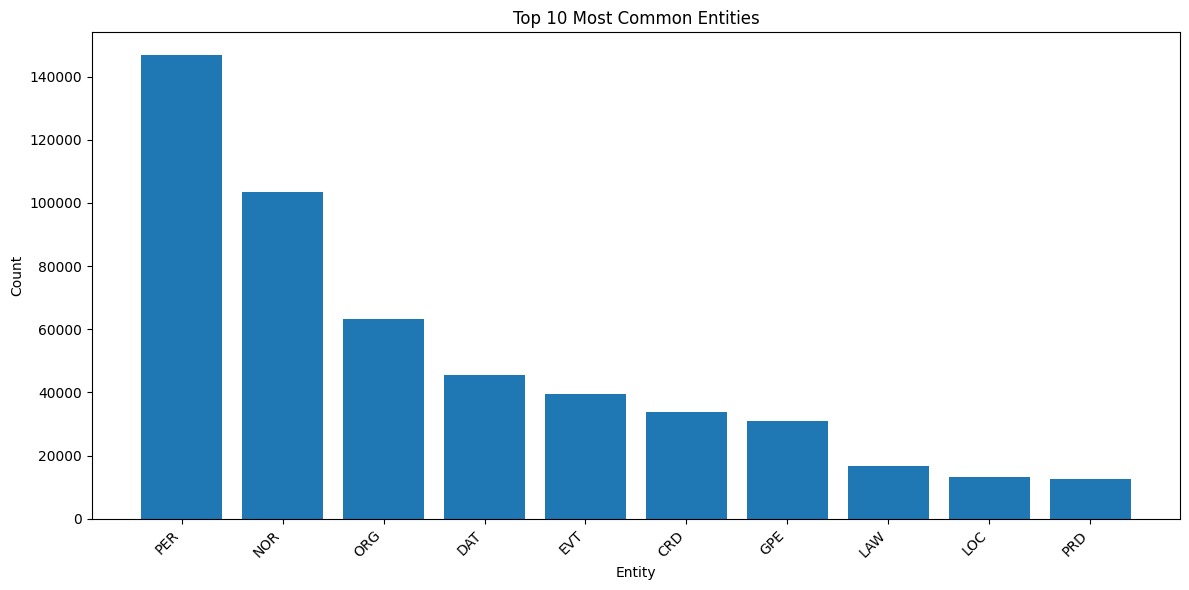

In [80]:
# Visualisasi
top_entities = global_entity_counter.most_common(10)
entities, counts = zip(*top_entities)

plt.figure(figsize=(12, 6))
plt.bar(entities, counts)
plt.title('Top 10 Most Common Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Analisis NER

* PER (146710): Ini mengacu pada "Person" atau orang. Jumlahnya yang tinggi menunjukkan bahwa berita politik Indonesia sering berfokus pada individu-individu tertentu.
* NOR (103489): Kemungkinan mengacu pada "Nominal" atau angka. Frekuensinya yang tinggi menunjukkan banyak penggunaan data numerik dalam berita politik.
* ORG (63237): Mengacu pada "Organization" atau organisasi. Ini menunjukkan bahwa partai politik, lembaga pemerintah, dan organisasi lainnya sering disebutkan.
* DAT (45661): Mengacu pada "Date" atau tanggal. Menunjukkan bahwa berita politik sering merujuk pada waktu atau tanggal tertentu.
* EVT (39647): Mungkin mengacu pada "Event" atau peristiwa. Menunjukkan banyak pembahasan tentang acara atau kejadian politik.
* CRD (33716): Mungkin mengacu pada "Cardinal" atau angka kardinal. Ini bisa terkait dengan statistik atau perhitungan dalam berita politik.
* GPE (30821): Kemungkinan mengacu pada "Geopolitical Entity" atau entitas geopolitik. Menunjukkan referensi yang sering ke negara, kota, atau wilayah.
* LAW (16628): Mengacu pada hukum atau undang-undang. Menunjukkan diskusi yang signifikan tentang aspek hukum dalam politik.
* LOC (13095): Mengacu pada "Location" atau lokasi. Menunjukkan referensi ke tempat-tempat tertentu dalam berita politik.
* PRD (12680): Mungkin mengacu pada "Product" atau produk. Dalam konteks politik, ini bisa merujuk pada kebijakan atau program tertentu.